## Time Series Forecasting 4

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### ARIMA Model : Finding P, D and Q

As we saw the AR stands for **AutoRegression**, which focuses on making predictions on future values based on passed values. 

**Integration** focuses on replacing values with the differences between previous values. Differencing is the computing of the differences between consecutive values. The goal is to make the time series stationary.

**Moving Average** focuses on correcting regression errors over time. A moving average is just the smoothed out real values and it is created by removing noise in the data. 

Non-seasonal ARIMA models have 3 parameters. Number of time lags of the AR model **p**, how many times we have to difference the data **d** and **q** represents the order of the MA model.

We have to decide if we need to difference our data and it is also common to only use AR or MA. 

If your autocorrelation plot has a positive autocorrelation at lag 1 you should use AR. If it is negative you should use MA. 

### Analyzing Weather Data Monthly

Dickey-Fuller Test
Test Statistic                -6.013137e+00
p-value                        1.556204e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.610000e+02
dtype: float64


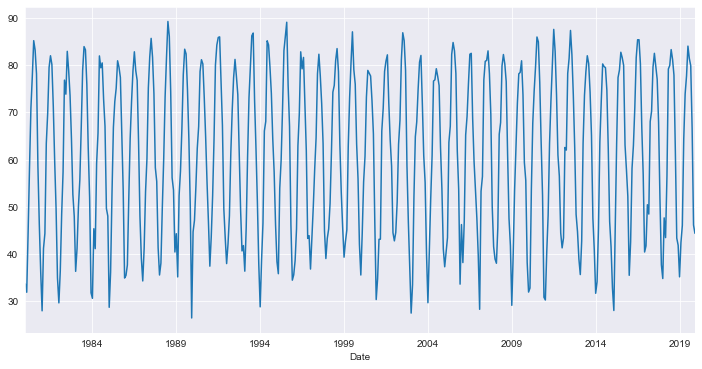

In [648]:
pitt_df = pd.read_csv('PittsburghWeather.csv', index_col='Date', parse_dates=True)
pitt_df = pitt_df.drop(['tmin', 'prcp'], axis=1)

# Get data since 1980
pitt_df = pitt_df[pitt_df.index>'1980-01-01']
pitt_df = pitt_df.asfreq('d') # Change frequency to day
pitt_df = pitt_df.fillna(method='ffill')
pitt_df.index # Check frequency

# Resample data using month instead of day
pitt_df = pitt_df['tmax'].resample(rule='MS').mean()
pitt_df.plot()

# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is under .05 that means
# there is a very low probability that our results are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

# Highly stationary (Low P-Value)
adf_test(pitt_df)


### Auto Correlation Function

Used to identify a MA model.

Auto Regressive Integrated Moving Average (ARIMA) based models forecast a time series based on past data and forecast errors.

The ACF and PACF provide parameters for ARIMA models.

2 groups of data that move in like ways are said to be correlated. Correlation is measured between the values of -1 (Inverse Correlation) to 0 (No Relationship) to 1 (Strongly Correlated).

With auto correlation we compare data to itself shifted a defined amount of time. For example we could shift a week and determine if last weeks performance is correlated to this week.

With auto correlation the y access is the correlation and x is the time shift amount. This way we can see how well our data is correlated over time.

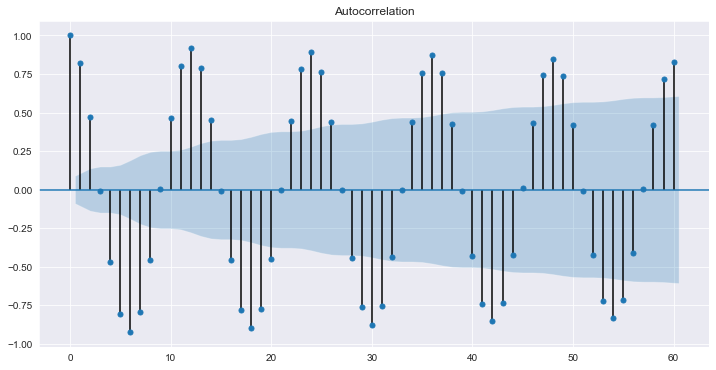

In [647]:
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf

acf(pitt_df, fft=False)

# Squeeze squeezes single column dataframes to a series
# Lag defines how much we want to shift the data
# The area shadded in blue is very likely to be in correlation
# That means they line up well with a regression line (Average)
# The blue area represents 95% of the correlated data
sm.graphics.tsa.plot_acf(pitt_df.values.squeeze(), lags=60);


### Partial Auto Correlation Function

Used to identify an AR model. If there is a gradual decline that suggests that we use an MA model.

An auto correlation has both a direct and indirect correlation. The PAC tries to remove those indirect correlations. With it we look for the difference between our linear model and the actual results. This difference is called the residual. We then plot those residuals. This works best with data that tends to be stationary.

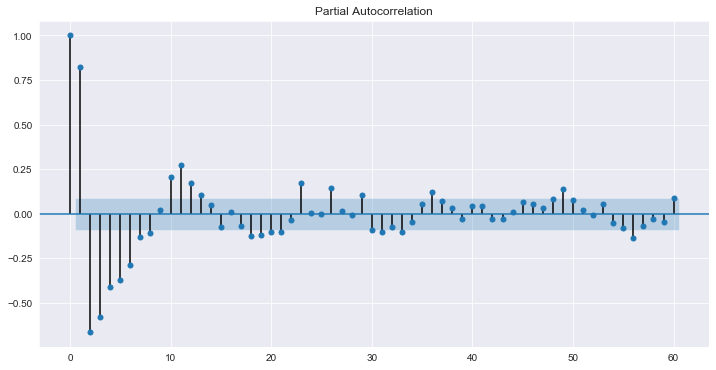

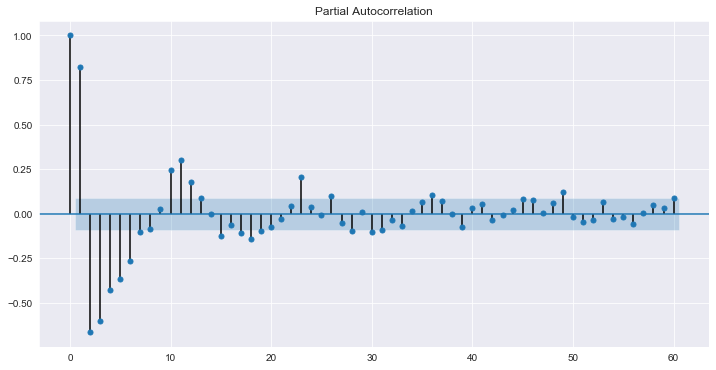

In [646]:
from statsmodels.tsa.stattools import pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_pacf

# There are different ways to measure correlation and 
# different ways of measuring partial auto correlation
# Also ywm, ldunbiased, ldbiased (Levinson-Durbin recursion)
sm.graphics.tsa.plot_pacf(pitt_df.values.squeeze(), lags=60,
                          method='ywunbiased');

sm.graphics.tsa.plot_pacf(pitt_df.values.squeeze(), lags=60,
                         method='ols');

# Non-recursive yule_walker
# Steps through the data and removes that weighting that effects
# all the data
# pacf_yw(pitt_df);

# OLS Ordinary Least Squares : Estimates the data so a line can 
# be drawn through data points
# pacf_ols(pitt_df);


### Grid Search

Often reading the ACF and PACF plots can be difficult. In those situations it is better to perform a **Grid Search**. A Grid Search tests numerous combinations of the p, d and q values to see which perform best.

The Pyramid ARIMA library is used to perform grid searches. It wil tell you if you should use an ARIMA or Seasonal ARIMA model. The Pyramid library uses the Akaike Information Criterion (AIC) to compare the performance.

### Akaike Information Criterion (AIC)

Akaike Information Criterion (AIC) analyzes multiple models and makes estimates on the quality of each model in relation to them. AIC aims to find the simpliest model that represents what we are studying even if a much more complex model performs slightly better. It does this by penalizying for using a large number of parameters. When referring to AIC we often talk about overfitted models. These are models that perform well during the training phase, but not during forecasting.

Bayesian Information Criterion (BIC) is similar to AIC aside from being different mathematically. 

### Pyramid ARIMA

In [659]:
# Install in your terminal or command line
# pip install pmdarima
from pmdarima import auto_arima
# help(auto_arima) Get info on parameters

# Turn off warnings that can be distracting and of no concern
import warnings
warnings.filterwarnings('ignore')

# start_p = 0 assumes there is no AR component
# start_q = 0 also to suggest no order for MA
# Define we are searching for 24 different models 6 * 4
# Seasonal is set to False since it is stationary
# Trace shows the 1st couple ARIMA models it tried to fit
step_fit = auto_arima(pitt_df, start_p=0, start_q=0, 
                      max_p=5, max_q=3, 
                      seasonal=False, trace=True)

# Returns AIC and BIC which estimate the quality of the models
# Then summary provides the best performing model
step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5347.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3581.108, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4761.543, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3425.661, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3417.572, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3363.796, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3276.687, Time=0.09 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2989.579, Time=0.51 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3092.827, Time=0.47 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2868.175, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3407.840, Time=0.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2941.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  480
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -1427.087
Date:                Fri, 06 Nov 2020   AIC                           2868.175
Time:                        10:38:06   BIC                           2897.391
Sample:                             0   HQIC                          2879.659
                                - 480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2891      0.037     61.741      0.000       2.216       2.362
ar.L2         -1.5272      0.101    -15.193      0.000      -1.724      -1.330
ar.L3         -0.1969      0.101     -1.959      0.050      -0.394    9.66e-05
ar.L4          0.4350      0.037     11.740      0.000       0.362       0.508
ma.L1         -1.7701      0.022    -80.546      0.000      -1.813      -1.727
ma.L2          0.9156      0.021     43.007      0.000       0.874       0.957
sigma2        21.5023      1.352     15.901      0.000      18.852      24.153
===================================================================================
Ljung-Box (Q):                      134.50   Jarque-Bera (JB):                 2.30
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               1.34   Skew:                             0.08
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA and Non-Stationary Data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.19 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 06 Nov 2020   AIC                           1019.178
Time:                                     10:38:21   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (Q):                       53.71   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.07   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

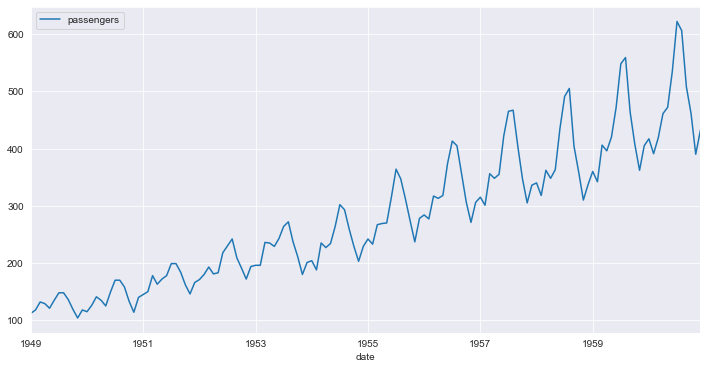

In [660]:
flight_df = sns.load_dataset('flights')
flight_df['day'] = '01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%B').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop('year', axis=1, inplace=True)
flight_df.drop('month', axis=1, inplace=True)
flight_df.drop('day', axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df.index.freq = 'MS'
flight_df.plot()

# This time seasonal is set to True
# m is the number of periods per season 4 quarterly,
# 12 monthly, etc.
step_fit2 = auto_arima(flight_df['passengers'], 
                       start_p=0, start_q=0, max_p=5, max_q=3, 
                       seasonal=True, trace=True, m=12)

step_fit2.summary()